# iminuit: Past and Future

Hans Dembinski

TU Dortmund, Germany

## Introduction to iminuit

PyPI          | https://pypi.org/project/iminuit
:-------------|:--------------------------------------
Code          | https://github.com/scikit-hep/iminuit
Documentation | http://iminuit.readthedocs.org
Gitter        | https://gitter.im/Scikit-HEP/community

### iminuit is a minimizer and error computation tool
- General purpose tool to minimize statistical cost functions with box constraints and to compute parameter uncertainties
    - Latter is unique, other libraries do not offer that
- Robust technology from 1975 that stood the tests of time
- Python frontend to MINUIT2 C++ code used by ROOT (shares all features and updates of the ROOT version)
- MINUIT is driving virtually every HEP analysis

#### Minimization

- Migrad: Newton-steps with along-the-way updated hessian matrix + fallback to steepest descent with line search + various heuristics to deal with sticky situations

#### Uncertainty computation
- Hesse algorithm, 1D intervals and ND contours
- Minos algorithm, 1D intervals and ND contours
- Different pros and cons, Hesse recommended as default (more later)

### A bit of (version) history

#### Fortran
- Original MINUIT in Fortran (1975)

#### C/C++
- TMinuit: Original ported to C and integrated into ROOT (~2000)
- Minuit2 (aka SEAL Minuit): Standalone rewrite of MINUIT in C++ (2002-2006)

#### Python
- pyminuit, pyminuit2
    - First MINUIT Python wrappers by Jim Pivarski
    - Feature highlight: auto-detection of parameter names in functions
- iminuit
    - Rewrite from scratch using Cython by Piti Ongmongkolkul
    - Interface compatible with pyminuit
    - *i* for interactive: Pretty display of fit status in Jupyter notebooks
    - HD took over as maintainer in 2019
        - Tighter intergration with numpy
            - Support functions that accept parameters as numpy arrays
            - Access to parameters and covariance matrix as numpy arrays
        - Support for modifying fit state between fitting steps
            - Fix and release parameters
            - Change parameter values
        - Lots of bug-fixes
        - Code sharing with ROOT C++
        - Improved interface
            - Rounding of sharp edges (easier and safer use)
            - Missing MINUIT core functionality: modifyable parameter state
        - Added lots of documentation and tutorials
        - CI build Python wheels and conda packages
            - Wheel scripts pioneered and contributed by Henry Schreiner
        - New library of cost functions (more later)
        - Current version: 1.4.5

# Simple fit

We do a simple fit with iminuit.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from iminuit import Minuit

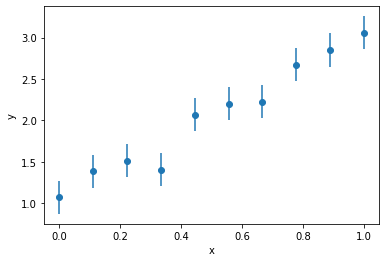

In [2]:
# make 10 data points with scatter on y-coordinate

rng = np.random.default_rng(1)

x = np.linspace(0, 1, 10)
ye = np.ones_like(x) * 0.2
y = 2 * x + 1 + ye * rng.normal(size=len(x))

plt.errorbar(x, y, ye, fmt="o")
plt.xlabel("x")
plt.ylabel("y");

To recover the parameters of the line, we need to write a model and a cost function. The model predicts a y value for an x value, using a set of parameters. The cost function must compute some kind of distance between the model predictions and the observations.

Optimal for this case is the least-squares method, where the cost function is the sum of squared studentized residuals.

In [3]:
# line model
def model(x, a, b):
    return a + b * x

def cost(a, b):
    ym = model(x, a, b)
    res = (y - ym) / ye # studentized residuals
    return np.sum(res ** 2)

# initialize Minuit object by passing the cost function
# - Minuit uses a local minimizer, we need to set starting values
# - Minuit also needs an `errordef` parameter (more later)
m = Minuit(cost, a=0, b=0, errordef=1)
m.params

------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | a    |    0.0    |    0.1    |            |            |         |         |       |
| 1 | b    |    0.0    |    0.1    |            |            |         |         |       |
------------------------------------------------------------------------------------------

Note: Minuit detected that the cost function has two parameters named `a` and `b`.

The Minuit object represents the current state of the fit. The initial state consists of the starting values and some step sizes (here 0.1) for the numerical gradient computation. You can set the step sizes yourself, with `error_a=...` etc, but a good default is selected for you if you do not.

Minuit makes it easy to interact with the fitter, which is useful for debugging and to manually help the minimizer to find the minimum. It also presents useful diagnostics that indicate if something went wrong.

In [4]:
# calling Migrad minimizer 
m.migrad()

------------------------------------------------------------------
| FCN = 3.959                   |      Ncalls=34 (34 total)      |
| EDM = 1.09e-22 (Goal: 0.0002) |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | a    |   1.05    |   0.12    |            |            |         |         |       |
| 1 | b    |   1.99    |   0.20    |            |            |         |         |       |
------------------------------------------------------------------------------------------

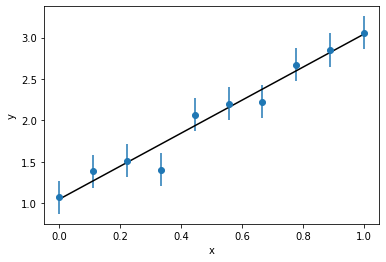

In [5]:
plt.errorbar(x, y, ye, fmt="o")
plt.xlabel("x")
plt.ylabel("y")
plt.plot(x, model(x, *m.values[:]), color="k"); # trick to access values as a tuple

The "Hesse Errors" now show estimated uncertainties of the parameters. *Migrad* computes these mostly for free as part of its minimization process.

Things to note:
- **EDM**: estimated distance to minimum, must be smaller than "Goal"; shows that Migrad converged
- **Ncalls**: How many function calls were used by Migrad (and the total by this Minuit object so far)
- **Pos. def.**: Whether the Hessian matrix (matrix of second derivatives) is positive definite; it must be for a valid minimum

The "Minos Errors" are not automatically computed. You need to run *Minos* explicitly.

In [6]:
m.minos()

------------------------------------------------------------
|          |           a           |           b           |
------------------------------------------------------------
|  Error   |   -0.12   |   0.12    |   -0.2    |    0.2    |
|  Valid   |   True    |   True    |   True    |   True    |
| At Limit |   False   |   False   |   False   |   False   |
| Max FCN  |   False   |   False   |   False   |   False   |
| New Min  |   False   |   False   |   False   |   False   |
------------------------------------------------------------

In such a simple fit, the Minos and Hesse uncertainty estimates are equal, but in non-parabolic cost functions they are not.

The Minos and Hesse uncertaintes are now nicely comparable in the parameter display.

In [7]:
m.params

------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | a    |   1.05    |   0.12    |   -0.12    |    0.12    |         |         |       |
| 1 | b    |   1.99    |   0.20    |   -0.20    |    0.20    |         |         |       |
------------------------------------------------------------------------------------------

They can be read-out with the following attribute (read-only).

In [8]:
a_me = m.merrors["a"] # returns a data struct with many fields
print(f"Did Minos work for parameter {a_me.name}? {a_me.is_valid}\n"
      f"lower error={a_me.lower:.3} upper error={a_me.upper:.3}")

Did Minos work for parameter a? True
lower error=-0.118 upper error=0.118


Much more information can be pulled from this object. Try `dir(a_me)`.

# Interactively manipulate fit state

Let's mess around. Let's say we know that `a = 1`, what is the value of `b` then? We can fix `a` and set its value, and then run *Migrad* again.

We can manipulate Minuit with the attributes `m.values`, `m.fixed`, and `m.errors` (to set different step sizes).

In [9]:
m.values["a"] = 1
m.fixed["a"] = True
m.migrad()

------------------------------------------------------------------
| FCN = 4.127                   |      Ncalls=8 (66 total)       |
| EDM = 1.51e-20 (Goal: 0.0002) |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | a    |   1.00    |   0.12    |   -0.12    |    0.12    |         |         |  yes  |
| 1 | b    |   2.06    |   0.11    |   -0.20    |    0.20    |         |         |       |
------------------------------------------------------------------------------------------

This took Minuit only 8 calls, because it was already close to the minimum and because it could *reuse information from the previous minimization*. This is another **key feature** that other minimizers lack.

The value and error of `b` changed a bit. Let's see how `b` varies when we scan over `a`.

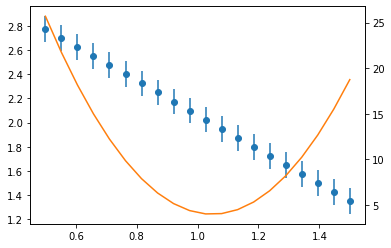

In [10]:
a = np.linspace(0.5, 1.5, 20)
b = []
be = []
fval = []
for ai in a:
    m.values["a"] = ai
    m.migrad()
    assert m.valid # easy check that the fit is valid
    fval.append(m.fval) # get value of cost function
    b.append(m.values["b"])
    be.append(m.errors["b"])

# values and uncertainty of b as a function of a, also shown is the function minimum
plt.errorbar(a, b, be, fmt="o", color="C0")
plt.twinx()
plt.plot(a, fval, color="C1");

The uncertainty estimate does not change, because the cost function has a constant second derivative, and Minuit uses the second derivative by default to estimate the uncertainty ("Hesse method").

Let's see how the corresponding lines look like. 

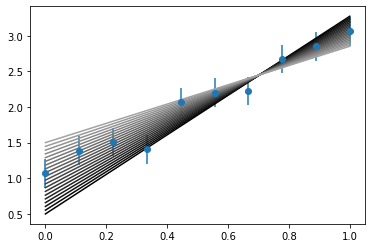

In [11]:
plt.errorbar(x, y, ye, fmt="o")
for i, (ai, bi) in enumerate(zip(a, b)):
    plt.plot(x, model(x, ai, bi), color=f"{i / 30.}")

**Mechanical analog**: **stiff rod** attached to the data points with **springs** of constant tension. If both `a` and `b` are minimized, Migrad finds the minimum energy configuration. This is also true, if `a` is externally constrained to other values (fixed during minimization).

# Cost functions

Minuit now comes with builtin cost functions, which can be imported from `iminuit.cost`. Currently available:

- Unbinned negative log-likelihood
- Extended unbinned negative log-likelihood
- Binned negative log-likelihood
- Extended binned negative log-likelihood
- Least-squares
- Robust least-squares

The `errordef` parameter is automatically set correctly for these.

As a particle physicist, you will often fit some peak over background. Let's do that.

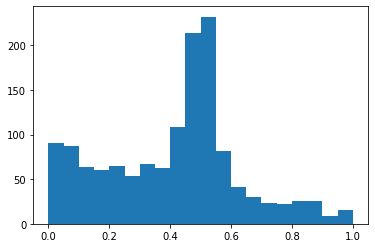

In [12]:
from scipy import stats

rng = np.random.default_rng(1)

x = np.append(stats.norm(0.5, 0.05).rvs(size=500, random_state=rng),
              stats.expon(0.0, 0.5).rvs(size=1000, random_state=rng))

plt.hist(x, bins=20, range=(0, 1));

In [13]:
# extended binned maximum likelihood fit
from iminuit.cost import ExtendedBinnedNLL

n, xe = np.histogram(x, bins=20, range=(0, 1)) # or use boost_histogram here!


# ExtendedBinnedNLL wants a model that returns the expected counts per bin

def signal(xe, ns, mu, sigma):
    return ns * stats.norm(mu, sigma).cdf(xe)


def background(xe, nb, lambd):
    return nb * stats.expon(0.0, lambd).cdf(xe)


def total(xe, ns, mu, sigma, nb, lambd):
    return signal(xe, ns, mu, sigma) + background(xe, nb, lambd)

cost = ExtendedBinnedNLL(n, xe, total)

# - lambd parameter of exponential distribution must be positive
# - sigma parameter of normal distribution must be positive
m = Minuit(cost, ns=1, mu=1, sigma=1, nb=1, lambd=1,
           limit_lambd=(0, None),
           limit_sigma=(0.01, None))
m.migrad()

------------------------------------------------------------------
| FCN = -4639                   |     Ncalls=415 (426 total)     |
| EDM = 43 (Goal: 0.0001)       |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   True    |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   False   |  True  |
------------------------------------------------------------------
-------------------------------------------------------------------------------------------
|   | Name  |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
-------------------------------------------------------------------------------------------
| 0 | ns    |  1.49e3   |  0.28e3   |            |            |         |         |       |
| 1 | mu    |   0.371   |   0.023   |            |            |         |         |       |
| 2 | sigma |   0.267   |   0.025   |            |            |  0.01   |         |       |
| 3 | nb    |    1e3    |    5e3    |            |            |         |         |       |
| 4 | lambd |     0     |   2.3e3   |            |            |    0    |         |       |
-------------------------------------------------------------------------------------------

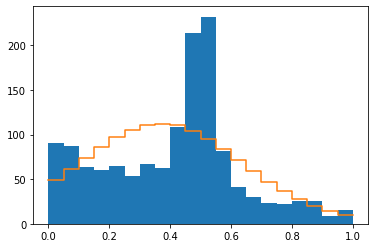

In [14]:
# let's draw this
def plot_model(xe, cdf): # helper function
    plt.plot(xe, np.append(np.diff(cdf), np.nan), drawstyle="steps-post")

plt.hist(x, bins=20, range=(0, 1));
plot_model(xe, total(xe, *m.values[:]))

That didn't work, the *EDM* value is bad and the fit looks bad. We need better starting values. Let's mask out the signal and fit only the background. The cost function has a `mask` attribute for that.

In [15]:
# signal window is roughly 0.3 to 0.7, let's mask that out
cx = 0.5 * (xe[1:] + xe[:-1]) # compute bin centers

cost.mask = (cx < 0.3) | (0.7 < cx)

# fix signal parameters for next fit and set signal amplitude to zero
m.fixed[:3] = True
m.values["ns"] = 0

m.migrad()

------------------------------------------------------------------
| FCN = -1617                   |     Ncalls=88 (514 total)      |
| EDM = 2.72e-05 (Goal: 0.0001) |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
-------------------------------------------------------------------------------------------
|   | Name  |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
-------------------------------------------------------------------------------------------
| 0 | ns    |     0     |  0.28e3   |            |            |         |         |  yes  |
| 1 | mu    |   0.371   |   0.023   |            |            |         |         |  yes  |
| 2 | sigma |   0.267   |   0.025   |            |            |  0.01   |         |  yes  |
| 3 | nb    |  1.01e3   |  0.06e3   |            |            |         |         |       |
| 4 | lambd |   0.55    |   0.04    |            |            |    0    |         |       |
-------------------------------------------------------------------------------------------

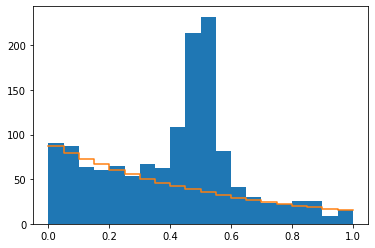

In [16]:
plt.hist(x, bins=20, range=(0, 1));
plot_model(xe, total(xe, *m.values[:]))

Much better! We now unmask the signal, fix the background parameters and only fit the signal.

In [17]:
cost.mask = None
m.fixed[:] = False
m.fixed["nb"] = True
m.fixed["lambd"] = True
m.values["ns"] = 1
m.migrad()

------------------------------------------------------------------
| FCN = -4842                   |     Ncalls=182 (696 total)     |
| EDM = 6.19e-06 (Goal: 0.0001) |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
-------------------------------------------------------------------------------------------
|   | Name  |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
-------------------------------------------------------------------------------------------
| 0 | ns    |    507    |    27     |            |            |         |         |       |
| 1 | mu    |  0.4985   |  0.0029   |            |            |         |         |       |
| 2 | sigma |  0.0460   |  0.0029   |            |            |  0.01   |         |       |
| 3 | nb    |  1.01e3   |  0.06e3   |            |            |         |         |  yes  |
| 4 | lambd |   0.55    |   0.04    |            |            |    0    |         |  yes  |
-------------------------------------------------------------------------------------------

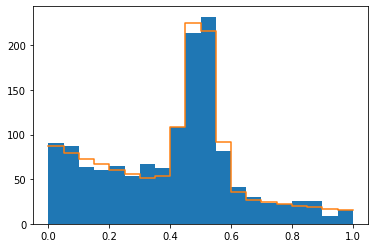

In [18]:
plt.hist(x, bins=20, range=(0, 1));
plot_model(xe, total(xe, *m.values[:]))

To wrap things up, we let Minuit optimize everything together.

In [19]:
m.fixed[:] = False
m.migrad()

------------------------------------------------------------------
| FCN = -4843                   |     Ncalls=97 (793 total)      |
| EDM = 3.95e-06 (Goal: 0.0001) |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
-------------------------------------------------------------------------------------------
|   | Name  |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
-------------------------------------------------------------------------------------------
| 0 | ns    |    496    |    29     |            |            |         |         |       |
| 1 | mu    |  0.4986   |  0.0029   |            |            |         |         |       |
| 2 | sigma |  0.0449   |  0.0030   |            |            |  0.01   |         |       |
| 3 | nb    |  1.06e3   |  0.05e3   |            |            |         |         |       |
| 4 | lambd |   0.56    |   0.04    |            |            |    0    |         |       |
-------------------------------------------------------------------------------------------

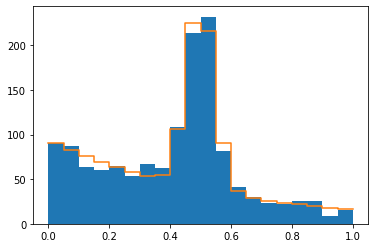

In [20]:
plt.hist(x, bins=20, range=(0, 1));
plot_model(xe, total(xe, *m.values[:]))

🎉🎉🎉

# Check out more great iminuit tutorials

https://nbviewer.jupyter.org/github/scikit-hep/iminuit/tree/master/tutorial/

* How Hesse and Minos really work, which to use when, and is Minos really better? *The answer may surprise you.*
* How to use the new cost functions
* How to use automatic differentation with iminuit
* How to use numba to accelerate cost functions